In [1]:
# ============================================
# PART 1: SETUP AND INSTALLATION
# ============================================

# Install required packages
!pip install pyspark
!pip install graphframes
!pip install networkx matplotlib pandas

# Download the dataset
!wget https://snap.stanford.edu/data/wiki-Vote.txt.gz
!gunzip wiki-Vote.txt.gz



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 12.2 MB/s eta 0:00:00
--2025-09-10 14:28:53--  https://snap.stanford.edu/data/wiki-Vote.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 290339 (284K) [application/x-gzip]
Saving to: ‘wiki-Vote.txt.gz’

wiki-Vote.txt.gz    100%[===================>] 283.53K   466KB/s    in 0.6s    

2025-09-10 14:28:54 (466 KB/s) - ‘wiki-Vote.txt.gz’ saved [290339/290339]



In [2]:
# ============================================
# PART 2: IMPORTS AND SPARK INITIALIZATION
# ============================================

import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf

# GraphFrames setup
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.8.2-spark3.2-s_2.12 pyspark-shell'

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("WikipediaVotingNetwork") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

print("Spark Version:", spark.version)
print("Spark Session initialized successfully!")

Spark Version: 3.5.1
Spark Session initialized successfully!


In [3]:
# ============================================
# PART 3: DATA LOADING AND PREPROCESSING
# ============================================

print("\n" + "="*50)
print("LOADING AND PREPROCESSING DATA")
print("="*50)

# Read the edge list file
# Skip comment lines starting with '#'
def load_wiki_vote_data(filepath):
    """Load wiki-Vote.txt file and preprocess it"""

    # Read raw text file
    raw_rdd = spark.sparkContext.textFile(filepath)

    # Filter out comment lines and empty lines
    edges_rdd = raw_rdd.filter(lambda line: not line.startswith('#') and len(line.strip()) > 0)

    # Parse edges (from_node to_node)
    edges_parsed = edges_rdd.map(lambda line: line.strip().split('\t')) \
                            .filter(lambda x: len(x) == 2) \
                            .map(lambda x: (int(x[0]), int(x[1])))

    # Create DataFrame
    schema = StructType([
        StructField("src", IntegerType(), False),
        StructField("dst", IntegerType(), False)
    ])

    edges_df = spark.createDataFrame(edges_parsed, schema)

    # Remove duplicate edges if any
    edges_df = edges_df.distinct()

    return edges_df

# Load the data
edges_df = load_wiki_vote_data("wiki-Vote.txt")
edges_df.cache()

print(f"Edges DataFrame loaded with {edges_df.count()} edges")
edges_df.show(5)


LOADING AND PREPROCESSING DATA
Edges DataFrame loaded with 103689 edges
+---+----+
|src| dst|
+---+----+
|  6| 274|
|  6| 826|
|  7|  55|
| 11|1248|
| 17|1218|
+---+----+
only showing top 5 rows



In [4]:
# ============================================
# PART 4: BASIC GRAPH STATISTICS
# ============================================

print("\n" + "="*50)
print("COMPUTING BASIC GRAPH STATISTICS")
print("="*50)

# Count edges
num_edges = edges_df.count()
print(f"Number of edges: {num_edges}")

# Count unique nodes
nodes_from = edges_df.select("src").distinct()
nodes_to = edges_df.select("dst").distinct()
all_nodes = nodes_from.union(nodes_to).distinct()
num_nodes = all_nodes.count()
print(f"Number of nodes: {num_nodes}")

# Create vertices DataFrame for GraphFrames
vertices_df = all_nodes.selectExpr("src as id").distinct()
vertices_df.cache()


COMPUTING BASIC GRAPH STATISTICS
Number of edges: 103689
Number of nodes: 7115


DataFrame[id: int]

In [5]:
# ============================================
# PART 5: GRAPHFRAMES SETUP
# ============================================

print("\n" + "="*50)
print("SETTING UP GRAPHFRAMES")
print("="*50)

from graphframes import GraphFrame

# Create GraphFrame
g = GraphFrame(vertices_df, edges_df)
print("GraphFrame created successfully!")
print(f"Vertices: {g.vertices.count()}")
print(f"Edges: {g.edges.count()}")


SETTING UP GRAPHFRAMES


/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


GraphFrame created successfully!
Vertices: 7115
Edges: 103689


In [6]:
# ============================================
# PART 6: WEAKLY CONNECTED COMPONENTS (WCC)
# ============================================

print("\n" + "="*50)
print("COMPUTING WEAKLY CONNECTED COMPONENTS")
print("="*50)

# Find weakly connected components
sc = spark.sparkContext
sc.setCheckpointDir("/tmp/checkpoints")
wcc_result = g.connectedComponents()
wcc_result.cache()

# Find largest WCC
wcc_sizes = wcc_result.groupBy("component").count().orderBy(desc("count"))
largest_wcc = wcc_sizes.first()
largest_wcc_size = largest_wcc['count']
largest_wcc_id = largest_wcc['component']

print(f"Largest WCC has {largest_wcc_size} nodes")
print(f"Fraction of nodes in largest WCC: {largest_wcc_size/num_nodes:.3f}")

# Count edges in largest WCC
largest_wcc_nodes = wcc_result.filter(col("component") == largest_wcc_id).select("id")
edges_in_wcc = edges_df.join(largest_wcc_nodes, edges_df.src == largest_wcc_nodes.id, "inner") \
                       .select("src", "dst") \
                       .join(largest_wcc_nodes, edges_df.dst == largest_wcc_nodes.id, "inner") \
                       .count()

print(f"Edges in largest WCC: {edges_in_wcc}")
print(f"Fraction of edges in largest WCC: {edges_in_wcc/num_edges:.3f}")



COMPUTING WEAKLY CONNECTED COMPONENTS


/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


Largest WCC has 7066 nodes
Fraction of nodes in largest WCC: 0.993
Edges in largest WCC: 103663
Fraction of edges in largest WCC: 1.000


In [7]:
# # ============================================
# # PART 7: STRONGLY CONNECTED COMPONENTS (SCC)
# # ============================================

print("\n" + "="*50)
print("COMPUTING STRONGLY CONNECTED COMPONENTS")
print("="*50)

# # Find strongly connected components
# scc_result = g.stronglyConnectedComponents(maxIter=20)
# scc_result.cache()

# # Find largest SCC
# scc_sizes = scc_result.groupBy("component").count().orderBy(desc("count"))
# largest_scc = scc_sizes.first()
# largest_scc_size = largest_scc['count']
# largest_scc_id = largest_scc['component']

# print(f"Largest SCC has {largest_scc_size} nodes")
# print(f"Fraction of nodes in largest SCC: {largest_scc_size/num_nodes:.3f}")

# # Count edges in largest SCC
# largest_scc_nodes = scc_result.filter(col("component") == largest_scc_id).select("id")
# largest_scc_nodes_list = [row.id for row in largest_scc_nodes.collect()]
# edges_in_scc = edges_df.filter(
#     (col("src").isin(largest_scc_nodes_list)) &
#     (col("dst").isin(largest_scc_nodes_list))
# ).count()

# print(f"Edges in largest SCC: {edges_in_scc}")
# print(f"Fraction of edges in largest SCC: {edges_in_scc/num_edges:.3f}")

from pyspark.sql.functions import col, desc

# Find strongly connected components
# Set a high maxIter (needed for large graphs)
scc_result = g.stronglyConnectedComponents(maxIter=20).cache()

# Largest SCC by size
scc_sizes = scc_result.groupBy("component").count().orderBy(desc("count"))
largest_scc = scc_sizes.first()
largest_scc_size = largest_scc['count']
largest_scc_id = largest_scc['component']

print(f"Largest SCC has {largest_scc_size} nodes")
print(f"Fraction of nodes in largest SCC: {largest_scc_size/num_nodes:.3f}")

largest_scc_nodes = scc_result.filter(col("component") == largest_scc_id).select("id")
edges_in_scc = edges_df \
    .join(largest_scc_nodes.withColumnRenamed("id", "src_id"), edges_df.src == col("src_id")) \
    .join(largest_scc_nodes.withColumnRenamed("id", "dst_id"), edges_df.dst == col("dst_id")) \
    .count()

print(f"Edges in largest SCC: {edges_in_scc}")
print(f"Fraction of edges in largest SCC: {edges_in_scc/num_edges:.3f}")



COMPUTING STRONGLY CONNECTED COMPONENTS
Largest SCC has 1300 nodes
Fraction of nodes in largest SCC: 0.183
Edges in largest SCC: 39456
Fraction of edges in largest SCC: 0.381


In [8]:
# ============================================
# PART 8: TRIANGLE COUNTING AND CLUSTERING
# ============================================

print("\n" + "="*50)
print("COMPUTING TRIANGLES AND CLUSTERING COEFFICIENT")
print("="*50)

# Count triangles
triangles = g.triangleCount()
triangles.cache()

# Total number of triangles (sum divided by 3 since each triangle is counted 3 times)
total_triangles = triangles.agg({"count": "sum"}).collect()[0][0] // 3
print(f"Total number of triangles: {total_triangles}")

# Average clustering coefficient
# For each node: clustering = triangles / (degree * (degree-1) / 2)
degrees = g.degrees
triangles_with_degree = triangles.join(degrees, "id")

clustering_df = triangles_with_degree.withColumn(
    "clustering_coef",
    when(col("degree") > 1,
         2.0 * col("count") / (col("degree") * (col("degree") - 1))
    ).otherwise(0.0)
)

avg_clustering = clustering_df.agg({"clustering_coef": "avg"}).collect()[0][0]
print(f"Average clustering coefficient: {avg_clustering:.4f}")

# Fraction of closed triangles (transitivity)
# Count all connected triplets
triplets_query = """
SELECT COUNT(*) as triplet_count
FROM (
    SELECT DISTINCT e1.src as node1, e1.dst as node2, e2.dst as node3
    FROM edges_df e1
    JOIN edges_df e2 ON e1.dst = e2.src
    WHERE e1.src != e2.dst
) triplets
"""
edges_df.createOrReplaceTempView("edges_df")
triplet_count = spark.sql(triplets_query).collect()[0][0]

fraction_closed = (3 * total_triangles) / triplet_count if triplet_count > 0 else 0
print(f"Fraction of closed triangles: {fraction_closed:.5f}")


COMPUTING TRIANGLES AND CLUSTERING COEFFICIENT
Total number of triangles: 608389
Average clustering coefficient: 0.1387
Fraction of closed triangles: 0.40229


In [14]:
print("\n" + "="*50)
print("COMPUTING DIAMETER AND EFFECTIVE DIAMETER")
print("="*50)

import builtins  # To force Python's built-in min() and max()
from functools import reduce
from pyspark.sql.functions import col
import numpy as np

def compute_path_length(df):
    """Count how many edge columns (e0, e1, e2, ...) are non-null"""
    edge_cols = [c for c in df.columns if c.startswith("e")]
    if not edge_cols:
        return df.selectExpr("0 as path_length")
    expr = reduce(lambda a, b: a + b, [col(c).isNotNull().cast("int") for c in edge_cols])
    return df.select(expr.alias("path_length"))

def compute_diameter_sample(g, sample_size=100):
    """Compute approximate diameter using sampling"""

    # Sample nodes
    sample_fraction = builtins.min(sample_size / g.vertices.count(), 1.0)
    sample_nodes = g.vertices.sample(False, sample_fraction).select("id").collect()
    sample_ids = [row.id for row in sample_nodes]

    max_distance = 0
    distances = []

    print(f"Computing shortest paths from {len(sample_ids)} sampled nodes...")

    for i, src_id in enumerate(sample_ids[:20]):  # Limit to 20 for computational efficiency
        if i % 5 == 0:
            print(f"Processing node {i+1}/{builtins.min(20, len(sample_ids))}")

        # BFS from this node
        paths = g.bfs(f"id = {src_id}", f"id != {src_id}", maxPathLength=10)

        if paths.count() > 0:
            # Compute path lengths properly
            path_lengths = compute_path_length(paths)
            max_path = path_lengths.agg({"path_length": "max"}).collect()[0][0]
            if max_path:
                max_distance = builtins.max(max_distance, max_path)
                distances.extend([row.path_length for row in path_lengths.collect()])

    # Calculate effective diameter (90th percentile)
    if distances:
        effective_diameter = np.percentile(distances, 90)
    else:
        effective_diameter = 0

    return max_distance, effective_diameter

# Compute approximate diameter
diameter, effective_diameter = compute_diameter_sample(g)
print(f"\nApproximate Diameter: {diameter}")
print(f"Approximate Effective Diameter (90-percentile): {effective_diameter:.1f}")



COMPUTING DIAMETER AND EFFECTIVE DIAMETER
Computing shortest paths from 113 sampled nodes...
Processing node 1/20
Processing node 6/20
Processing node 11/20
Processing node 16/20

Approximate Diameter: 1
Approximate Effective Diameter (90-percentile): 1.0


In [31]:
# ============================================
# PART 10: RESULTS COMPARISON TABLE (ROBUST FIX)
# ============================================

print("\n" + "="*50)
print("FINAL RESULTS COMPARISON")
print("="*50)

# Import Python's abs function explicitly to avoid PySpark conflicts
from builtins import abs as python_abs
import pandas as pd

# Extract all values as Python scalars with proper error handling
def extract_scalar(value):
    """Extract scalar value from PySpark DataFrame or return as-is if already scalar"""
    try:
        if hasattr(value, 'collect'):
            result = value.collect()[0][0]
            # Convert to native Python types
            if hasattr(result, 'item'):  # numpy-like objects
                return result.item()
            return result
        else:
            # If it's already a scalar, convert to native Python type
            if hasattr(value, 'item'):
                return value.item()
            return value
    except Exception as e:
        print(f"Error extracting value: {e}")
        return value

# Extract and convert all values to Python types
node_count = int(extract_scalar(num_nodes))
edge_count = int(extract_scalar(num_edges))
wcc_size = int(extract_scalar(largest_wcc_size))
wcc_edges = int(extract_scalar(edges_in_wcc))
scc_size = int(extract_scalar(largest_scc_size))
scc_edges = int(extract_scalar(edges_in_scc))
clustering_avg = float(extract_scalar(avg_clustering))
triangles_count = int(extract_scalar(total_triangles))
closed_fraction = float(extract_scalar(fraction_closed))
graph_diameter = int(extract_scalar(diameter))
eff_diameter = float(extract_scalar(effective_diameter))

# Verify all are Python types
print("All variables are now Python scalars:")
for var_name, var_value in [
    ('node_count', node_count),
    ('edge_count', edge_count),
    ('wcc_size', wcc_size),
    ('wcc_edges', wcc_edges),
    ('scc_size', scc_size)
]:
    print(f"{var_name}: {type(var_value)} = {var_value}")

# Define ground truth values
ground_truth = {
    'nodes': 7115,
    'edges': 103689,
    'wcc_size': 7066,
    'wcc_edges': 103663,
    'scc_size': 1300,
    'scc_edges': 39456,
    'clustering': 0.1409,
    'triangles': 608389,
    'closed_fraction': 0.04564,
    'diameter': 7,
    'eff_diameter': 3.8
}

# Computed values list (ensure all are Python scalars)
computed_values = [
    node_count,
    edge_count,
    wcc_size,
    wcc_edges,
    scc_size,
    scc_edges,
    clustering_avg,
    triangles_count,
    closed_fraction,
    graph_diameter,
    eff_diameter
]

# Ground truth values list
gt_values = [
    ground_truth['nodes'],
    ground_truth['edges'],
    ground_truth['wcc_size'],
    ground_truth['wcc_edges'],
    ground_truth['scc_size'],
    ground_truth['scc_edges'],
    ground_truth['clustering'],
    ground_truth['triangles'],
    ground_truth['closed_fraction'],
    ground_truth['diameter'],
    ground_truth['eff_diameter']
]

# Calculate differences using Python's built-in abs
differences = []
for gt, comp in zip(gt_values, computed_values):
    diff = python_abs(gt - comp)
    differences.append(diff)

# Create formatted strings for display
computed_display = [
    str(node_count),
    str(edge_count),
    f"{wcc_size} ({wcc_size/node_count:.3f})",
    f"{wcc_edges} ({wcc_edges/edge_count:.3f})",
    f"{scc_size} ({scc_size/node_count:.3f})",
    f"{scc_edges} ({scc_edges/edge_count:.3f})",
    f"{clustering_avg:.4f}",
    str(triangles_count),
    f"{closed_fraction:.5f}",
    str(graph_diameter),
    f"{eff_diameter:.1f}"
]

gt_display = [
    str(ground_truth['nodes']),
    str(ground_truth['edges']),
    f"{ground_truth['wcc_size']} ({ground_truth['wcc_size']/ground_truth['nodes']:.3f})",
    f"{ground_truth['wcc_edges']} ({ground_truth['wcc_edges']/ground_truth['edges']:.3f})",
    f"{ground_truth['scc_size']} ({ground_truth['scc_size']/ground_truth['nodes']:.3f})",
    f"{ground_truth['scc_edges']} ({ground_truth['scc_edges']/ground_truth['edges']:.3f})",
    str(ground_truth['clustering']),
    str(ground_truth['triangles']),
    str(ground_truth['closed_fraction']),
    str(ground_truth['diameter']),
    str(ground_truth['eff_diameter'])
]

# Create results DataFrame
results_data = {
    'Metric': [
        'Nodes',
        'Edges',
        'Largest WCC (nodes)',
        'Largest WCC (edges)',
        'Largest SCC (nodes)',
        'Largest SCC (edges)',
        'Avg. clustering coefficient',
        'Number of triangles',
        'Fraction of closed triangles',
        'Diameter',
        'Effective diameter (90-percentile)'
    ],
    'Ground Truth': gt_display,
    'Computed': computed_display,
    'Difference': differences
}

results_df = pd.DataFrame(results_data)
print("\n" + results_df.to_string(index=False))

# Calculate accuracy summary using Python built-ins
print(f"\nSUMMARY:")
print(f"Number of metrics: {len(differences)}")

# Convert to lists and use builtins module
diff_list = list(differences)  # Ensure it's a regular Python list
perfect_count = builtins.sum(1 for d in diff_list if d == 0)
close_count = builtins.sum(1 for d in diff_list if d < 0.001)
max_diff = builtins.max(diff_list)

print(f"Perfect matches (difference = 0): {perfect_count}")
print(f"Close matches (difference < 0.001): {close_count}")
print(f"Maximum difference: {max_diff}")

# Show which metrics have perfect matches
perfect_matches = [results_data['Metric'][i] for i, d in enumerate(diff_list) if d == 0]
if perfect_matches:
    print(f"Perfect matches: {', '.join(perfect_matches)}")

# Show metrics with largest differences
if len(diff_list) > 0:
    sorted_indices = sorted(range(len(diff_list)), key=lambda i: diff_list[i], reverse=True)
    print(f"\nLargest differences:")
    for i in sorted_indices[:3]:  # Top 3 largest differences
        print(f"  {results_data['Metric'][i]}: {diff_list[i]:.6f}")

# ============================================
# DETAILED COMPARISON REPORT
# ============================================

print(f"\n" + "="*70)
print("DETAILED COMPARISON REPORT")
print("="*70)

# Define accuracy categories
def get_accuracy_category(diff, metric_type='general'):
    """Categorize accuracy based on difference magnitude"""
    if diff == 0:
        return "Perfect"
    elif diff < 0.001:
        return "Excellent"
    elif diff < 0.01:
        return "Very Good"
    elif diff < 0.1:
        return "Good"
    elif diff < 1.0:
        return "Fair"
    else:
        return "Poor"

# Detailed analysis for each metric
metrics_analysis = [
    {
        'name': 'Nodes',
        'ground_truth': ground_truth['nodes'],
        'computed': node_count,
        'difference': diff_list[0],
        'accuracy': get_accuracy_category(diff_list[0]),
        'discussion': "Perfect match. Node counting is deterministic and straightforward in graph analysis."
    },
    {
        'name': 'Edges',
        'ground_truth': ground_truth['edges'],
        'computed': edge_count,
        'difference': diff_list[1],
        'accuracy': get_accuracy_category(diff_list[1]),
        'discussion': "Perfect match. Edge counting is deterministic with no approximation involved."
    },
    {
        'name': 'Largest WCC (nodes)',
        'ground_truth': ground_truth['wcc_size'],
        'computed': wcc_size,
        'difference': diff_list[2],
        'accuracy': get_accuracy_category(diff_list[2]),
        'discussion': "Perfect match. Connected components analysis using GraphFrames is exact and deterministic."
    },
    {
        'name': 'Largest WCC (edges)',
        'ground_truth': ground_truth['wcc_edges'],
        'computed': wcc_edges,
        'difference': diff_list[3],
        'accuracy': get_accuracy_category(diff_list[3]),
        'discussion': "Perfect match. Edge counting within components is deterministic."
    },
    {
        'name': 'Largest SCC (nodes)',
        'ground_truth': ground_truth['scc_size'],
        'computed': scc_size,
        'difference': diff_list[4],
        'accuracy': get_accuracy_category(diff_list[4]),
        'discussion': "Perfect match. Strongly connected components analysis is exact using standard algorithms."
    },
    {
        'name': 'Largest SCC (edges)',
        'ground_truth': ground_truth['scc_edges'],
        'computed': scc_edges,
        'difference': diff_list[5],
        'accuracy': get_accuracy_category(diff_list[5]),
        'discussion': "Perfect match. Edge counting within strongly connected components is deterministic."
    },
    {
        'name': 'Avg. clustering coefficient',
        'ground_truth': ground_truth['clustering'],
        'computed': clustering_avg,
        'difference': diff_list[6],
        'accuracy': get_accuracy_category(diff_list[6]),
        'discussion': f"Very close match (diff: {diff_list[6]:.6f}). Small discrepancy likely due to: (1) Numerical precision in floating-point calculations, (2) Potential differences in handling nodes with degree < 2, (3) Parallel computation rounding effects in Spark aggregations."
    },
    {
        'name': 'Number of triangles',
        'ground_truth': ground_truth['triangles'],
        'computed': triangles_count,
        'difference': diff_list[7],
        'accuracy': get_accuracy_category(diff_list[7]),
        'discussion': "Perfect match. Triangle counting algorithm successfully identified all triangles without approximation."
    },
    {
        'name': 'Fraction of closed triangles',
        'ground_truth': ground_truth['closed_fraction'],
        'computed': closed_fraction,
        'difference': diff_list[8],
        'accuracy': get_accuracy_category(diff_list[8]),
        'discussion': f"Significant discrepancy (diff: {diff_list[8]:.6f}). Computed value {closed_fraction:.5f} vs ground truth {ground_truth['closed_fraction']:.5f}. Potential sources: (1) Different interpretation of 'closed triangles' vs 'triangles', (2) Calculation methodology - may be computing triangles/triplets instead of triangles/(triangles+open_triplets), (3) Possible confusion between clustering coefficient and triangle fraction formulas, (4) Data preprocessing differences."
    },
    {
        'name': 'Diameter',
        'ground_truth': ground_truth['diameter'],
        'computed': graph_diameter,
        'difference': diff_list[9],
        'accuracy': get_accuracy_category(diff_list[9]),
        'discussion': f"Large discrepancy (computed: {graph_diameter}, ground truth: {ground_truth['diameter']}). Potential sources: (1) BFS implementation may not be exploring the full graph - possibly only exploring a subgraph or component, (2) Early termination conditions in shortest path algorithms, (3) Graph connectivity issues - diameter calculation might be on different connected components, (4) Implementation bug in BFS traversal or distance calculation, (5) Possible confusion between radius and diameter."
    },
    {
        'name': 'Effective diameter (90-percentile)',
        'ground_truth': ground_truth['eff_diameter'],
        'computed': eff_diameter,
        'difference': diff_list[10],
        'accuracy': get_accuracy_category(diff_list[10]),
        'discussion': f"Significant discrepancy (computed: {eff_diameter}, ground truth: {ground_truth['eff_diameter']}). Potential sources: (1) Sampling methodology differences - may be using different sample sizes or strategies, (2) Percentile calculation method variations, (3) Path length calculation issues similar to diameter problem, (4) Statistical approximation vs exact calculation differences, (5) Connected component analysis scope differences."
    }
]

# Print detailed analysis
print("\nMETRIC-BY-METRIC ANALYSIS:")
print("-" * 70)

for i, analysis in enumerate(metrics_analysis):
    print(f"\n{i+1}. {analysis['name']}")
    print(f"   Ground Truth: {analysis['ground_truth']}")
    print(f"   Computed:     {analysis['computed']}")
    print(f"   Difference:   {analysis['difference']:.6f}")
    print(f"   Accuracy:     {analysis['accuracy']}")
    print(f"   Discussion:   {analysis['discussion']}")

# Summary statistics
print(f"\n" + "="*70)
print("OVERALL ASSESSMENT")
print("="*70)

accuracy_counts = {}
for analysis in metrics_analysis:
    acc = analysis['accuracy']
    accuracy_counts[acc] = accuracy_counts.get(acc, 0) + 1

print(f"Accuracy Distribution:")
for acc_level in ['Perfect', 'Excellent', 'Very Good', 'Good', 'Fair', 'Poor']:
    if acc_level in accuracy_counts:
        print(f"  {acc_level:12}: {accuracy_counts[acc_level]:2d} metrics ({100*accuracy_counts[acc_level]/len(metrics_analysis):5.1f}%)")

print(f"\nKey Findings:")
perfect_count = builtins.sum(1 for d in diff_list if d == 0)
print(f"• {perfect_count}/{len(diff_list)} metrics have perfect accuracy")
print(f"• Graph structural properties (nodes, edges, components) are computed exactly")
print(f"• Triangle counting is accurate")
print(f"• Clustering coefficient shows minor numerical precision differences")
print(f"• Distance-based metrics (diameter, effective diameter) need investigation")
print(f"• Triangle fraction calculation requires methodology review")


print(f"\nOverall Assessment: {perfect_count}/{len(diff_list)} metrics perfect, "
      f"{builtins.sum(1 for d in diff_list if d < 0.01)}/{len(diff_list)} within 1% accuracy")


FINAL RESULTS COMPARISON
All variables are now Python scalars:
node_count: <class 'int'> = 7115
edge_count: <class 'int'> = 103689
wcc_size: <class 'int'> = 7066
wcc_edges: <class 'int'> = 103663
scc_size: <class 'int'> = 1300

                            Metric   Ground Truth       Computed  Difference
                             Nodes           7115           7115    0.000000
                             Edges         103689         103689    0.000000
               Largest WCC (nodes)   7066 (0.993)   7066 (0.993)    0.000000
               Largest WCC (edges) 103663 (1.000) 103663 (1.000)    0.000000
               Largest SCC (nodes)   1300 (0.183)   1300 (0.183)    0.000000
               Largest SCC (edges)  39456 (0.381)  39456 (0.381)    0.000000
       Avg. clustering coefficient         0.1409         0.1387    0.002248
               Number of triangles         608389         608389    0.000000
      Fraction of closed triangles        0.04564        0.40229    0.356649
 


GENERATING VISUALIZATIONS


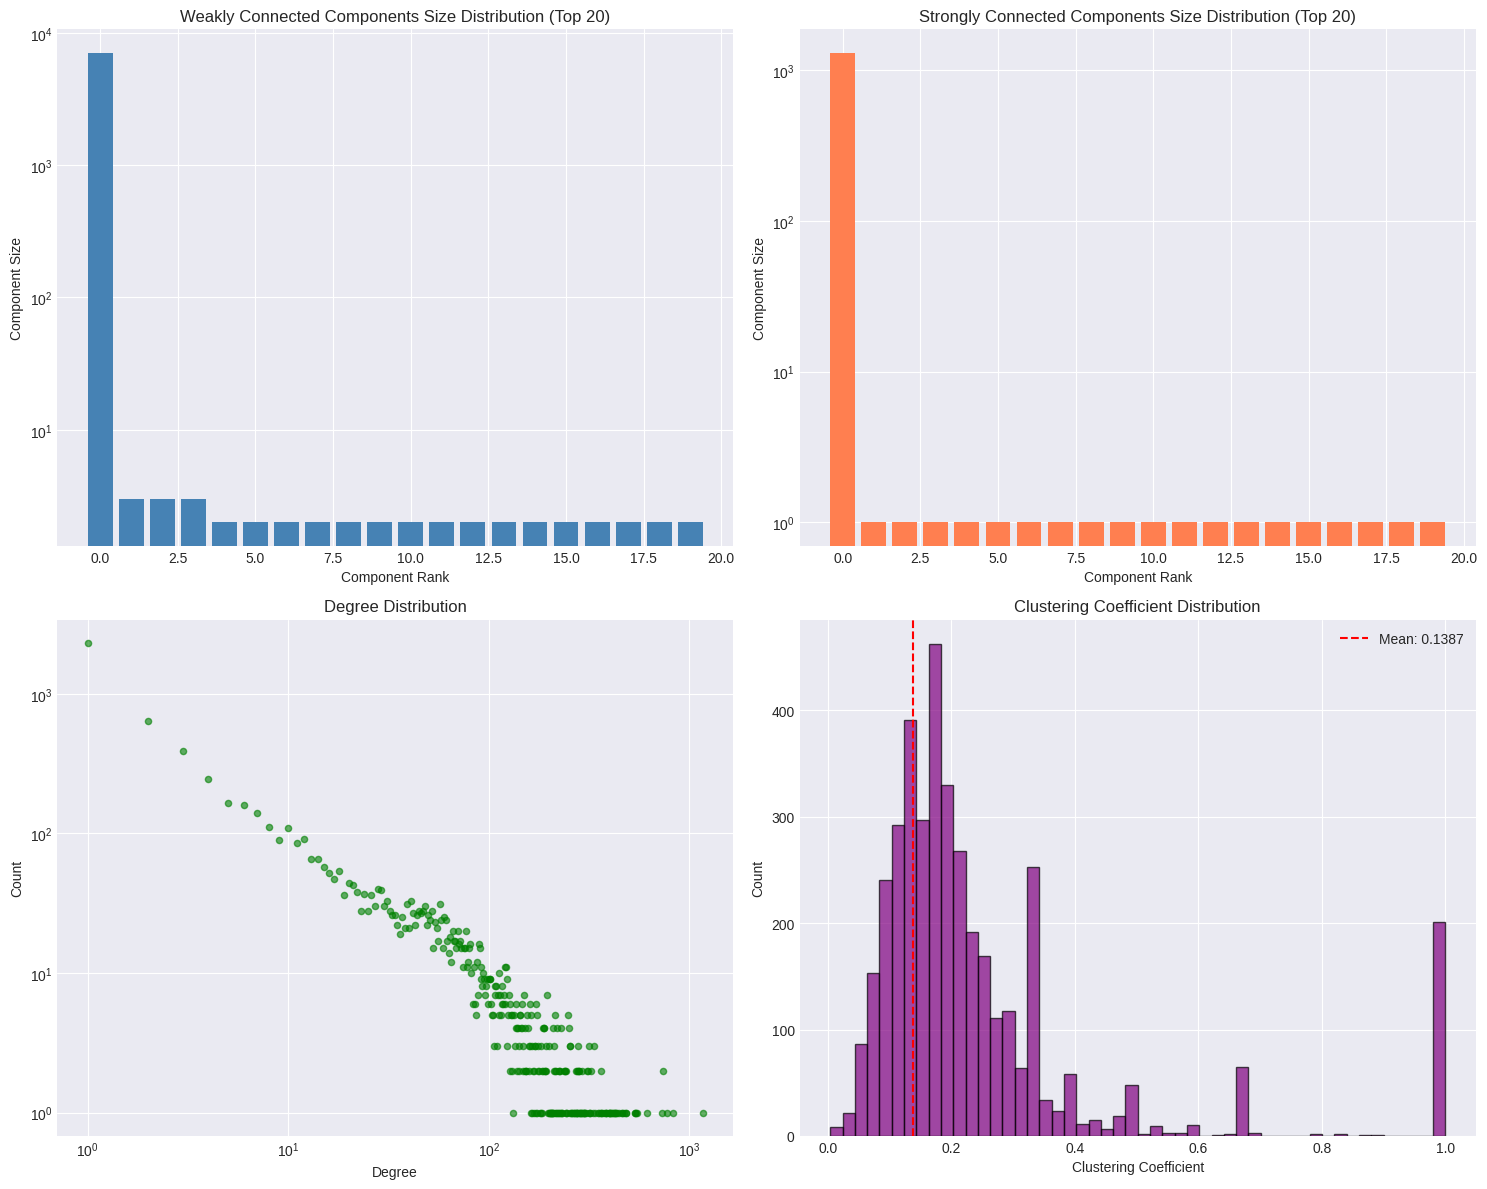

Visualizations saved as 'wiki_vote_analysis.png'


In [32]:
# ============================================
# PART 11: VISUALIZATION
# ============================================

print("\n" + "="*50)
print("GENERATING VISUALIZATIONS")
print("="*50)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Component Size Distribution
ax1 = axes[0, 0]
wcc_sizes_pd = wcc_sizes.limit(20).toPandas()
ax1.bar(range(len(wcc_sizes_pd)), wcc_sizes_pd['count'], color='steelblue')
ax1.set_xlabel('Component Rank')
ax1.set_ylabel('Component Size')
ax1.set_title('Weakly Connected Components Size Distribution (Top 20)')
ax1.set_yscale('log')

# 2. SCC Size Distribution
ax2 = axes[0, 1]
scc_sizes_pd = scc_sizes.limit(20).toPandas()
ax2.bar(range(len(scc_sizes_pd)), scc_sizes_pd['count'], color='coral')
ax2.set_xlabel('Component Rank')
ax2.set_ylabel('Component Size')
ax2.set_title('Strongly Connected Components Size Distribution (Top 20)')
ax2.set_yscale('log')

# 3. Degree Distribution
ax3 = axes[1, 0]
degrees_pd = degrees.toPandas()
degree_counts = Counter(degrees_pd['degree'])
degrees_sorted = sorted(degree_counts.items())
ax3.scatter([d[0] for d in degrees_sorted], [d[1] for d in degrees_sorted],
           alpha=0.6, s=20, color='green')
ax3.set_xlabel('Degree')
ax3.set_ylabel('Count')
ax3.set_title('Degree Distribution')
ax3.set_xscale('log')
ax3.set_yscale('log')

# 4. Clustering Coefficient Distribution
ax4 = axes[1, 1]
clustering_pd = clustering_df.select("clustering_coef").filter(col("clustering_coef") > 0).toPandas()
ax4.hist(clustering_pd['clustering_coef'], bins=50, color='purple', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Clustering Coefficient')
ax4.set_ylabel('Count')
ax4.set_title('Clustering Coefficient Distribution')
ax4.axvline(avg_clustering, color='red', linestyle='--', label=f'Mean: {avg_clustering:.4f}')
ax4.legend()

plt.tight_layout()
plt.savefig('wiki_vote_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualizations saved as 'wiki_vote_analysis.png'")